In [1]:
!pip install pytorch-lightning tensorboard h5py wget

In [2]:
# Download the dataset
# !wget -O cell_data.h5 "https://fz-juelich.sciebo.de/s/amYjlddoE59Alxk/download?path=%2Fcells%2Fcell_data.h5"

import os
file_path = "cell_data.h5"

if not os.path.exists(file_path):
    !wget -O cell_data.h5 "https://fz-juelich.sciebo.de/s/amYjlddoE59Alxk/download?path=%2Fcells%2Fcell_data.h5"
    print(f"Downloaded {file_path}")
else:
    print(f"{file_path} already exists. Skipping download.")

cell_data.h5 already exists. Skipping download.


In [3]:
# Verify the file was downloaded and check its size
!ls -lh cell_data.h5

-rw-r--r-- 1 root root 2.5G Nov 19 09:52 cell_data.h5


In [4]:
import wget
base_url = "https://raw.githubusercontent.com/HasanOJ/VAE-Olfactory-Tubercle/main/"

# List of files to download
files = ['src/model.py', 'src/data_processing.py', 'src/utils.py', 'statistics_cache.json']

# Download each file
for file in files:
    url = base_url + file
    if not os.path.exists(file.split('/')[-1]):
      wget.download(url)
      print(f"\nDownloaded {file}")

In [5]:
# Mount Google Drive if your data is stored there
# from google.colab import drive
# drive.mount('/content/drive')

config = {
    'img_channels': 1,
    'feature_dim': 128,
    'latent_dim': 128,
    'batch_size': 64,
    'learning_rate': 0.001,
    'max_epochs': 100,
    'test_set': 'B20',
    'data_path': 'cell_data.h5',
    'samples_per_epoch': 1024,
    'tile_size': 64
}

In [6]:
import argparse
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from model import VAE
from data_processing import BrainTileDataset, DensityBasedSampler
from utils import calculate_statistics, visualize_reconstruction, denormalize
import torch
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
import json
import os
# from /content/drive/MyDrive/HHU/Generative Models/VAE-Olfactory-Tubercle/src

torch.set_float32_matmul_precision('medium')

In [7]:
with h5py.File(config['data_path'], 'r') as f:
    config['brain_names'] = list(f.keys())

if config['test_set'] not in config['brain_names']:
    raise ValueError(f"Test set {config['test_set']} not found in HDF5 file.")

# Calculate global statistics
global_stats = calculate_statistics(config['data_path'], config['test_set'])
config['global_mean'] = global_stats['mean']
config['global_std'] = global_stats['std']

Loading cached statistics for test set B20...


In [8]:
train_dataset = BrainTileDataset(config['data_path'], global_stats,
                                test_set=config['test_set'],
                                tile_size=config['tile_size'])

test_dataset = BrainTileDataset(config['data_path'], global_stats,
                               test_set=config['test_set'],
                               tile_size=config['tile_size'],
                               testing=True)

# Create samplers
density_sampler = DensityBasedSampler(train_dataset,
                                     samples_per_epoch=config['samples_per_epoch'])
random_sampler = DensityBasedSampler(test_dataset,
                                    samples_per_epoch=config['samples_per_epoch'],
                                    density=False)

# Create dataloaders
density_dataloader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    sampler=density_sampler,
    num_workers=2,  # Reduced for Colab
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    sampler=random_sampler,
    shuffle=False,
    num_workers=2,  # Reduced for Colab
    pin_memory=True
)

In [9]:
model = VAE(
    in_channels=config['img_channels'],
    out_channels=config['img_channels'],
    latent_dim=config['latent_dim'],
    img_size=config['tile_size'],
    beta=4,
    gamma=1000,
    max_capacity=25,
    Capacity_max_iter=1e5,
    loss_type='H',
    hidden_dims=None
)
model.train()

# Set up logger and callbacks
logger = TensorBoardLogger("tb_logs", name=f"vae-{config['test_set']}-{config['latent_dim']}")

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename=f'best-checkpoint-{config["test_set"]}-{config["latent_dim"]}',
    save_top_k=1,
    mode='min',
    enable_version_counter=False
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    check_on_train_epoch_end=False
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Initialize trainer
trainer = Trainer(
    max_epochs=config['max_epochs'],
    logger=logger,
    accelerator="gpu" if torch.cuda.is_available() else "auto",
    devices=1 if torch.cuda.is_available() else "auto",
    callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
    precision='16-mixed' if torch.cuda.is_available() else '32-true',
    # log_every_n_steps=0
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model, density_dataloader, test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 2.1 M  | train
1 | decoder | Decoder | 1.8 M  | train
--------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.746    Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

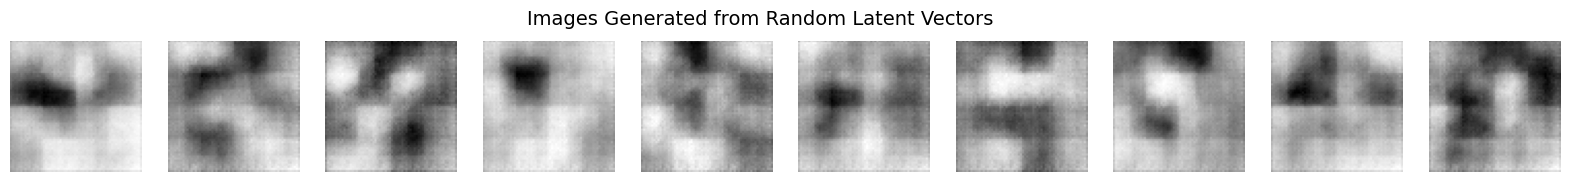

In [12]:
# Sample 10 random latent vectors from a standard Gaussian distribution
latent_vectors = torch.randn(10, model.latent_dim).to(device)

# Decode the latent vectors to generate images
with torch.no_grad():
    generated_images = model.decoder(latent_vectors)

# Visualize the generated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(denormalize(generated_images[i].permute(1, 2, 0).cpu().numpy(), global_stats['mean'], global_stats['std']), cmap='gray')
    ax.axis('off')
plt.suptitle("Images Generated from Random Latent Vectors", fontsize=14)
plt.show()

In [13]:
import gc

# Delete unused variables
del density_sampler
del density_dataloader
del test_dataloader
del train_dataset
del test_dataset
# Force garbage collection
gc.collect()

87

In [14]:
test_dataset = BrainTileDataset(config['data_path'], global_stats, test_set=config['test_set'], tile_size=64, testing=True, metadata=True)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
    sampler=random_sampler,
    shuffle=False,
)

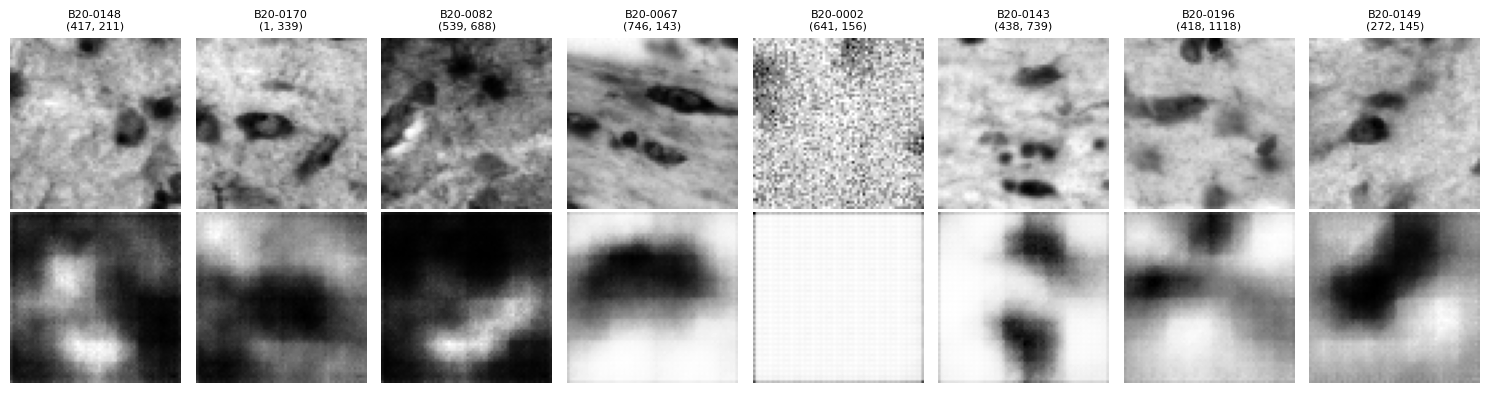

In [15]:
sample_batch, metadata = next(iter(test_dataloader))
sample_batch = sample_batch.to(device)
reconstructed, _, _ = model(sample_batch)
reconstructed_denormalized = denormalize(reconstructed.cpu(), global_stats['mean'], global_stats['std'])
visualize_reconstruction(sample_batch.cpu(), reconstructed_denormalized, metadata)
plt.show()

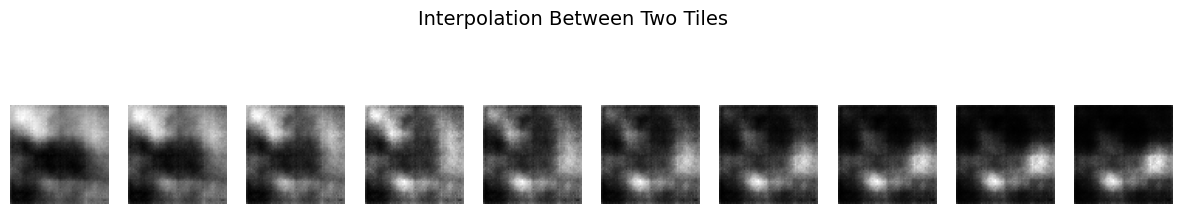

In [16]:
# Select two tiles and encode their latent representations
tile_1 = sample_batch[1].unsqueeze(0).to(device)
tile_2 = sample_batch[2].unsqueeze(0).to(device)

z1, _ = model.encoder(tile_1)  # Encode tile 1
z2, _ = model.encoder(tile_2)  # Encode tile 2

# Interpolate between latent representations
k = 10  # Number of interpolation steps
interpolated_latents = torch.stack([z1 + t * (z2 - z1) for t in torch.linspace(0, 1, k)], dim=0)

# Decode interpolated representations
interpolated_images = model.decoder(interpolated_latents).detach().cpu()

# Visualize the interpolation
fig, axes = plt.subplots(1, k, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i].squeeze(0), cmap='gray')
    ax.axis('off')
plt.suptitle("Interpolation Between Two Tiles", fontsize=14)
plt.show()

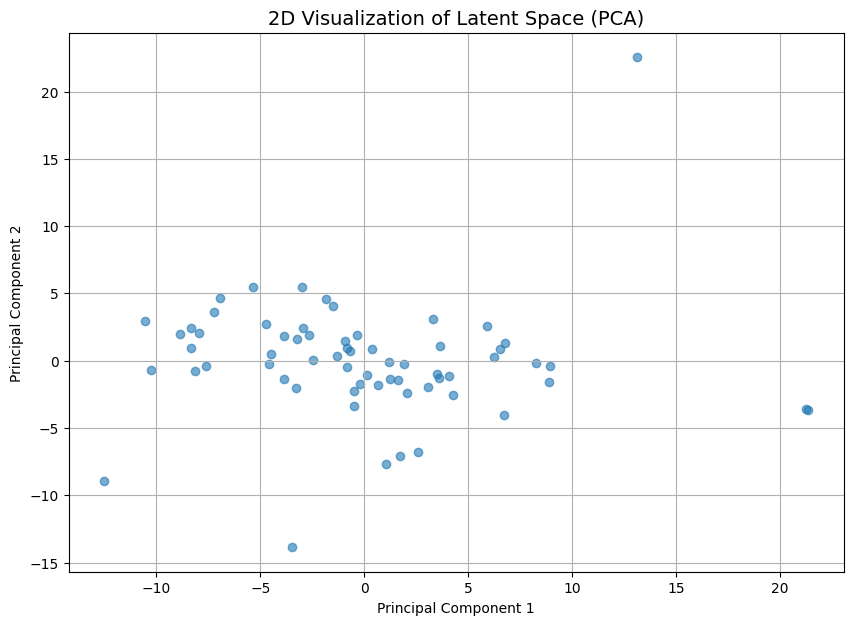

In [17]:
from sklearn.decomposition import PCA
# Sample 3000 tiles from the test dataset
num_tiles = 3000
sample_tiles ,metadata = next(iter(test_dataloader))[:num_tiles]
sample_tiles = sample_tiles.to(device)

# Encode tiles into latent representations
latent_representations, _ = model.encoder(sample_tiles)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_latents = pca.fit_transform(latent_representations.detach().cpu().numpy())

# Plot the 2D latent space
plt.figure(figsize=(10, 7))
plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], alpha=0.6)
plt.title("2D Visualization of Latent Space (PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()